In [1]:
## Import necessary stuff. 

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Special imports
import utils
import logomaker

# JAX imports
import jax.numpy as jnp
import jax.random as random

# Numpyro imports
import numpyro
from numpyro.diagnostics import hpdi
from numpyro.infer import Predictive
import numpyro.distributions as dist

#%matplotlib inline

In [2]:
# Set figure style
style_file_name = f'fig.style'
s = """
axes.linewidth:     1.0  # width of spines 
font.size:          7.0  # default font size
axes.labelsize:     7.0  # fontsize of the x any y labels
axes.titlesize:     7.0  # fontsize of title
xtick.labelsize:    7.0  # fontsize of the tick labels
ytick.labelsize:    7.0  # fontsize of the tick labels
legend.fontsize:      7.0
legend.borderpad:     0.2  # border whitespace
legend.labelspacing:  0.2  # the vertical space between the legend entries
legend.borderaxespad: 0.2  # the border between the axes and legend edge
axes.labelpad:      1.0     # space between label and axis
"""
with open(style_file_name, 'w') as f:
    f.write(s)
    
plt.style.use(style_file_name)

In [3]:
# generate random keys for training and predictions
rng_key, rng_key_predict = random.split(random.PRNGKey(0))

In [4]:
def load_data(sheet_name):
    # Name of excel file
    file_name = '../data/qPCR/dose_response_curves.xlsx'
    
    # Load data from Excel sheet
    data_df = pd.read_excel(file_name,
                            sheet_name=sheet_name, header=[0, 1], index_col=[0, 1])
    data_df.index.rename(['conc', 'bio_rep'], inplace=True)
    data_df.columns.rename(['primers', 'tech_rep'], inplace=True)

    # Pivot to make tidy data
    tidy_df = data_df.melt(value_name='cycles',
                           ignore_index=False).reset_index()
    
    # For each (conc, bio_rep) compute mean of cycles across tech_rep
    df = tidy_df.groupby(['conc','bio_rep','primers']).mean()['cycles'].to_frame().reset_index()
    df = df.pivot(index=['conc','bio_rep'],columns='primers', values='cycles')

    # Compute dCt values (NOTE: exclusion - inclusion !)
    df['dCt'] = df['exclusion'] - df['inclusion']
    df = df.reset_index()[['conc','bio_rep','dCt']]
    df.columns.name = ''
    
    return df

In [5]:
def load_mcmc_samples(sheet_name):
    mcmc_file_name = f'../mcmc_samples/mcmc_{sheet_name}.pkl'
    with open(mcmc_file_name, 'rb') as f:
        mcmc_samples = pickle.load(f)
    return mcmc_samples

In [6]:
### MUST BE SAME AS IN INFERENCE SCRIPT
def single_drug_model(x, y=None):

    # Context strength
    log10_S = numpyro.sample("log10_S", dist.Uniform(low=-3, high=3))
    S=numpyro.deterministic('S', 10.0**log10_S)

    # Hill coefficient
    log2_H = numpyro.sample("log2_H", dist.Normal(loc=0, scale=2))
    H=numpyro.deterministic('H', 2.0**log2_H)

    # Normalizing concentration
    log10_NC = numpyro.sample("log10_NC", dist.Uniform(low=-3, high=3))
    NC=numpyro.deterministic('NC',10.0**log10_NC)

    # Measurement noise
    log10_sigma = numpyro.sample("log10_sigma", dist.Uniform(low=-2, high=2))
    sigma = numpyro.deterministic('sigma',10.0**log10_sigma)

    # Amplitude
    log10_alpha = numpyro.sample("log10_alpha", dist.Uniform(low=0, high=6))
    alpha = numpyro.deterministic('alpha',10.0**log10_alpha)
    
    # R = inclusion / exclusion
    R = numpyro.deterministic('R', S*(1 + (x/NC)**H)/(1 + (1/alpha)*(x/NC)**H))
    log2_R = numpyro.deterministic('log2_R', jnp.log2(R))
    numpyro.sample('yhat', dist.Normal(log2_R, sigma), obs=y)

In [7]:
def log_ticks_from_lims(lim):   
    # Compute xticks and yticks
    log_tick_lo = np.ceil(np.log10(lim[0])).astype(int)
    log_tick_hi = np.floor(np.log10(lim[1])).astype(int)
    ticks = [10**tick for tick in range(log_tick_lo, log_tick_hi+1)]
    return ticks
    
log_ticks_from_lims([1E-3, 1E3])

[0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [17]:
def plot_single_drug(ax,
                     minigene,
                     drug,
                     sheet_name,
                     color,
                     xlim,
                     ylim,
                     show_ylabel=True,
                     show_yticklabels=True,
                     show_H=True,
                     show_EC2x=False,
                     units='nM',
                     text_fontsize=7,
                     two_lines=False):
    """Plots data for a single drug on top of model preditions for that drug."""

    # Get ticks
    xticks = log_ticks_from_lims(xlim)
    yticks = log_ticks_from_lims(ylim)

    # Load data
    data_df = load_data(sheet_name)
    x = data_df['conc'].values
    y = 2.**data_df['dCt'].values

    # Load MCMC samples
    mcmc_samples = load_mcmc_samples(sheet_name)

    # Define concentration grid
    x_grid = np.logspace(np.log10(xlim[0]),
                         np.log10(xlim[1]),
                         100)
    
    # Compute model predictions on grid
    ppc = Predictive(single_drug_model, mcmc_samples)
    ppc_val = ppc(rng_key_predict, x=x_grid)
    y_hat_grid = 2.**np.median(ppc_val['log2_R'], axis=0)
    y_lo_grid, y_hi_grid =  2.**hpdi(ppc_val['log2_R'], prob=0.95)

    # Plot predictive interval
    ax.fill_between(x_grid, 
                    y_lo_grid, 
                    y_hi_grid, 
                    alpha=0.2, 
                    interpolate=True,
                    linewidth=0,
                    color=color)

    # Plot median model prediction
    ax.plot(x_grid, 
            y_hat_grid, 
            c=color)

    # Plot data
    ix = x>0
    ax.scatter(x[ix], 
               y[ix], 
               s=10,
               alpha=.5,
               color='k', 
               zorder=100,
               linewidth=0)
    n_zero = sum(~ix)
    x_zero = xlim[0]*1.5*np.ones(n_zero)
    y_zero = y[~ix]
    ax.scatter(x_zero,
               y_zero,
               marker='<',
               s=10,
               alpha=.5,
               color='k', 
               zorder=100,
               linewidth=0)

    # Show H
    if show_H:
        H_med = np.median(mcmc_samples['H'])
        H_lo, H_hi = hpdi(mcmc_samples['H'])
        if two_lines:
            H_text = f'$H =${H_med:.2f}\n[{H_lo:.2f}, {H_hi:.2f}]' 
            ax.text(s=H_text, x=xlim[0]*1.5, y=ylim[1]/1.25, ha='left', va='top', fontsize=text_fontsize)

        else:
            H_text = f'$H =${H_med:.2f} [{H_lo:.2f}, {H_hi:.2f}]' 
            ax.text(s=H_text, x=xlim[0]*1.5, y=ylim[1]/1.5, ha='left', va='top', fontsize=text_fontsize)

    if show_EC2x:
        EC2x_med = np.median(mcmc_samples['NC'])
        EC2x_lo, EC2x_hi = hpdi(mcmc_samples['NC'])
        EC2x_text = f'$EC_{{2x}} =${EC2x_med:.2f} [{EC2x_lo:.2f}, {EC2x_hi:.2f}]' 
        ax.text(s=EC2x_text, x=xlim[0]*1.5, y=ylim[1]/1.5, ha='left', va='top', fontsize=text_fontsize)
            
    # Style plot
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(minigene)
    ax.set_xlabel(f'[{drug}] ({units})')
    ax.set_xticks(xticks)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_yticks(yticks)
    if show_ylabel:
        ax.set_ylabel(f'inclusion/exclusion')
    if not show_yticklabels:
        ax.set_yticklabels([])
    ax.tick_params(axis='both', which='minor', left=False, bottom=False)

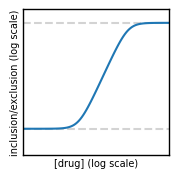

In [9]:
# Fig5B
fig, ax = plt.subplots(1,1,figsize=[1.8,1.8])

xlim = np.array([10**-1, 10**5])
x = np.logspace(*np.log10(xlim),100)
ylim = [3E-3, 1E3]

H = 2
K = 20
M = 1E4
S = 3E-2

y = S*(1 + (x/K)**H)/(1 + (1/M)*(x/K)**H)

ax.plot(x,y)
ax.set(xscale='log',
       yscale='log',
       xlim=xlim,
       ylim=ylim,
       xticks=[],
       yticks=[])
ax.axhline(S, linestyle='--', color='lightgray', zorder=-100)
ax.axhline(M*S, linestyle='--', color='lightgray', zorder=-100)
ax.minorticks_off()
ax.set_ylabel('inclusion/exclusion (log scale)', labelpad=2)
ax.set_xlabel('[drug] (log scale)', labelpad=2)
plt.tight_layout()
#ax.set_facecolor('none')
fig.savefig('fig5D.pdf', facecolor='none')

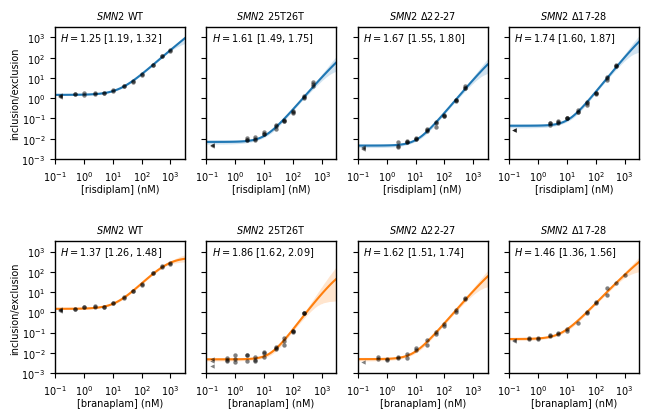

In [10]:
# Fig5CD
fig, axs = plt.subplots(2,4,figsize=[6.5, 4.2])

# Define panel contents
minigenes = ['$SMN2$ WT', '$SMN2$ 25T26T', '$SMN2$ Δ22-27', '$SMN2$ Δ17-28']
drugs = ['risdiplam','branaplam']
sheet_names = np.array([['t25a_ris_v2',  'smn2_pt1_ris',  'smn2_pt2_ris',  'smn2_pt3_ris'],
                        ['t25a_bran_v5', 'smn2_pt1_bran', 'smn2_pt2_bran_v2', 'smn2_pt3_bran_v2']])
colors = ['C0','C1']

# Plot panels
for i in range(2):
    for j in range(4):
        plot_single_drug(ax=axs[i,j],
                         minigene=minigenes[j],
                         drug=drugs[i],
                         sheet_name=sheet_names[i,j],
                         color=colors[i],
                         show_ylabel=(j==0),
                         show_yticklabels=(j==0),
                         xlim=[10**-1.0, 10**3.5],
                         ylim=[10**-3, 10**3.5],
                         text_fontsize=7)

fig.tight_layout(w_pad=1, h_pad=3)
fig.savefig(f'fig5E-L.pdf', facecolor='white')

In [11]:
# Quantifry reduction in context strength

sheet_names = np.array(['t25a_ris_v2',  'smn2_pt1_ris',  'smn2_pt2_ris',  'smn2_pt3_ris',
                        't25a_bran_v5', 'smn2_pt1_bran', 'smn2_pt2_bran_v2', 'smn2_pt3_bran_v2'])

# # Iterate over sheets
# S_med_dict = {}
# for sheet_name in sheet_names:
    
#     # Load MCMC samples
#     mcmc_samples = load_mcmc_samples(sheet_name)
#     Ss = 10**mcmc_samples['log10_S']
#     S_med = np.median(Ss)
#     S_lo, S_hi = hpdi(Ss, prob=0.95)
#     print(f'{sheet_name}: {S_med:.2e} [{S_lo:.2e}, {S_hi:.2e}]')
    
sheet_pairs = [
    ('t25a_ris_v2','smn2_pt1_ris'),
    ('t25a_ris_v2','smn2_pt2_ris'),
    ('t25a_ris_v2','smn2_pt3_ris'),
#     ('t25a_bran_v5','smn2_pt1_bran'),
#     ('t25a_bran_v5','smn2_pt2_bran'),
#     ('t25a_bran_v5','smn2_pt3_bran'),    
]
for top_sheet, bottom_sheet in sheet_pairs:
    
    top_Ss = 10**load_mcmc_samples(top_sheet)['log10_S']
    bottom_Ss = 10**load_mcmc_samples(bottom_sheet)['log10_S']
    ratios = top_Ss/bottom_Ss
    ratios_med = np.median(ratios)
    ratios_lo, ratios_hi = hpdi(ratios, prob=0.95)
    print(f'{top_sheet}/{bottom_sheet}: {ratios_med:.0f}x [{ratios_lo:.0f}x, {ratios_hi:.0f}x]')
    

t25a_ris_v2/smn2_pt1_ris: 211x [165x, 265x]
t25a_ris_v2/smn2_pt2_ris: 320x [255x, 395x]
t25a_ris_v2/smn2_pt3_ris: 34x [26x, 42x]


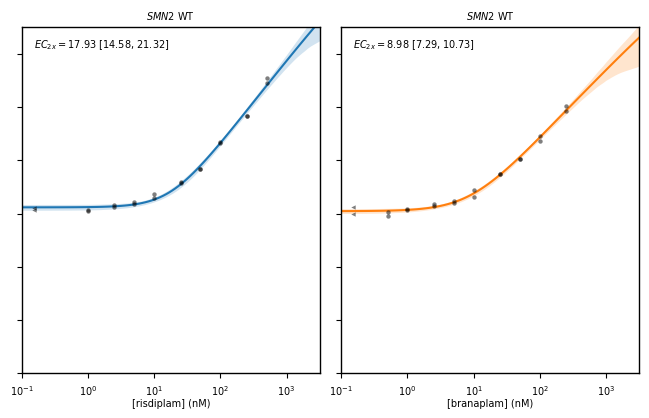

In [18]:
# Fig5CD
fig, axs = plt.subplots(1,2,figsize=[6.5, 4.2])

# Define panel contents
drugs = ['risdiplam','branaplam']
sheet_names = ['t25a_ris_pilot','t25a_bran_pilot']
colors = ['C0','C1']

# Plot panels
for i in range(2):
    plot_single_drug(ax=axs[i],
                     minigene='$SMN2$ WT',
                     drug=drugs[i],
                     sheet_name=sheet_names[i],
                     color=colors[i],
                     show_H=False,
                     show_EC2x=True,
                     show_ylabel=(j==0),
                     show_yticklabels=(j==0),
                     xlim=[10**-1.0, 10**3.5],
                     ylim=[10**-3, 10**3.5],
                     text_fontsize=7)

fig.tight_layout(w_pad=1, h_pad=3)
fig.savefig(f'figS1_pilot.pdf', facecolor='white')